In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from mvpa2.suite import SimpleSOMMapper
import cartopy.crs as ccrs

import xarray as xr
from xarray.core.common import _full_like as full_like

In [2]:
# projection class
class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)

In [3]:
ncfiles = {}
# Grid and domain files
ncfiles['rasm_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['rasm_ocn_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_POPCICE_GRID_MASKS_AND_METRICS.nc'
ncfiles['$RASM_{CONTROL}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/cpl/monthly_mean_timeseries/R1010RBRbaaa01a.cpl.ha.197909-201412_allvars.nc'
ncfiles['$RASM_{CONTROL}-LAND$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/lnd//monthly_mean_timeseries/R1010RBRbaaa01a.vic.hmm.197909-201412.nc'
ncfiles['$RASM_{CONTROL}-SEAICE$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/ice/monthly_mean_timeseries/R1010RBRbaaa01a.cice.hmm.197909-201412.nc'
ncfiles['$RASM_{CONTROL}-OCN$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/ocn/monthly_mean_timeseries/R1010RBRbaaa01a.pop.h.197909-201412.nc'

ncdata = {}
for k, v in ncfiles.items():
    try:
        ncdata[k] = xr.open_dataset(v)
    except ValueError:
        ncdata[k] = xr.open_dataset(v, decode_times=False)
        print('need to manually set the dates for %s' % k)

ncdata['$RASM_{CONTROL}$'] = ncdata['$RASM_{CONTROL}$'].rename({'a2xavg_nx': 'ni',
 'a2xavg_ny': 'nj',
 'l2xavg_nx': 'ni',
 'l2xavg_ny': 'nj',
 'x2aavg_nx': 'ni',
 'x2aavg_ny': 'nj',
 'x2lavg_nx': 'ni',
 'x2lavg_ny': 'nj'})

need to manually set the dates for $RASM_{CONTROL}-OCN$


In [4]:
# missing 1983-06, not sure why but we don't need it for this analysis
fnames = ncdata['$RASM_{CONTROL}-OCN$'].attrs['history'].split()[10:-2]
dates = []
from datetime import datetime
for fname in fnames:
    year, month = map(int, fname.split('.')[-2].split('-'))
    dates.append(datetime(year, month, 1))
ncdata['$RASM_{CONTROL}-OCN$']['time'] = pd.DatetimeIndex(dates)


In [5]:
ncdata['$RASM_{CONTROL}$'].coords['xc'] = ncdata['rasm_domain']['xc']
ncdata['$RASM_{CONTROL}$'].coords['yc'] = ncdata['rasm_domain']['yc']
for v in ['mask', 'frac', 'area']:
    ncdata['$RASM_{CONTROL}$'][v] = ncdata['rasm_domain'][v]
ncdata['$RASM_{CONTROL}$']


<xarray.Dataset>
Dimensions:             (ni: 275, nj: 205, time: 424)
Coordinates:
  * time                (time) datetime64[ns] 1979-09-16 1979-10-16T12:00:00 ...
  * nj                  (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * ni                  (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    yc                  (nj, ni) float64 16.53 16.78 17.02 17.27 17.51 17.76 ...
    xc                  (nj, ni) float64 189.2 189.4 189.6 189.7 189.9 190.1 ...
Data variables:
    x2aavg_Sx_t         (time, nj, ni) float64 301.0 301.0 301.0 301.0 301.0 ...
    x2aavg_Faxx_evap    (time, nj, ni) float64 -1.511e-05 -2.826e-05 ...
    a2xavg_Sa_u         (time, nj, ni) float64 -6.78 -7.209 -7.2 -7.155 ...
    a2xavg_Sa_v         (time, nj, ni) float64 -1.536 -1.206 -1.159 -1.131 ...
    a2xavg_Sa_tbot      (time, nj, ni) float64 300.6 300.6 300.6 300.6 300.6 ...
    a2xavg_Sa_pbot      (time, nj, ni) float64 1.011e+05 1.012e+05 1.012e+05 ...
    a2xavg_Sa_pslv      (t

In [6]:
# ncdata['$RASM_{CONTROL}-SEAICE$'].time.values -= np.timedelta64(1, 'D')
# ncdata['$RASM_{CONTROL}-SEAICE$'] = ncdata['$RASM_{CONTROL}-SEAICE$'].resample('MS', ÷dim='time', how='first')
ncdata['$RASM_{CONTROL}-SEAICE$']['time'] = pd.date_range('1979-09', '2014-12', freq='MS')


In [7]:
total_precip = (ncdata['$RASM_{CONTROL}$'].a2xavg_Faxa_rainc +
                ncdata['$RASM_{CONTROL}$'].a2xavg_Faxa_rainl +
                ncdata['$RASM_{CONTROL}$'].a2xavg_Faxa_snowc +
                ncdata['$RASM_{CONTROL}$'].a2xavg_Faxa_snowl)

evap = ncdata['$RASM_{CONTROL}$'].x2aavg_Faxx_evap * -1


In [10]:
def anomalies(da, by='time.month', dim='time', standardize=True, base_period=None):
    if not base_period:
        base = da
    else:
        base = da.sel(time=base_period)
    
    dag = da.groupby(by)
    baseg = base.groupby(by)
    climatology = baseg.mean(dim)

    anomalies = (dag - climatology)
    if standardize:
        std = baseg.std(dim)
        anomalies = anomalies.groupby(by) / std        
    
    return anomalies

In [11]:
def set_map_features(ax, extent=[-180, 0,  53, 90]):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree())
    if extent:
        ax.set_extent(extent)


In [12]:
def anomalies(da, by='time.month', dim='time', standardize=True):
    g = da.groupby(by)
    climatology = g.mean(dim)

    anomalies = (g - climatology)
    if standardize:
        std = g.std(dim)
        anomalies = anomalies.groupby(by) / std
    
    return anomalies

In [13]:
precip_anoms = anomalies(total_precip, standardize=False)
precip_anoms_std = anomalies(total_precip, standardize=True)
evap_anoms = anomalies(evap, standardize=False)
temp_anoms = anomalies(ncdata['$RASM_{CONTROL}$'].a2xavg_Sa_tbot, standardize=False)
p_minus_e = (total_precip - evap)
p_minus_e_anoms = anomalies(p_minus_e, standardize=False)
sea_ice_anoms = anomalies(ncdata['$RASM_{CONTROL}-SEAICE$']['aice'], standardize=False)

In [14]:
data = precip_anoms_std.sel(time=precip_anoms_std.indexes['time'].month > 9)
ntime, ny, nx = data.shape
ys, xs = np.nonzero(
    ncdata['rasm_domain']['mask'].where(
        ncdata['rasm_domain']['mask'].yc > 55).values > 0)

nspace = len(ys)


print(data.shape)
# dr = data.values.reshape(ntime, nspace)
dr = data.values[:, ys, xs]
print(dr.shape)
som_shape = (3, 3)

(108, 205, 275)
(108, 11955)


In [28]:
som = SimpleSOMMapper(som_shape, 3000, learning_rate=0.001)
som

SimpleSOMMapper(kshape=(3, 3), niter=3000, learning_rate=0.001000, iradius=3.000000)

In [29]:
%time som.train(dr)

CPU times: user 6min 10s, sys: 18 ms, total: 6min 10s
Wall time: 6min 10s


In [30]:
# This gives us the location of each timestep in the SOM
som_inds = [tuple(si) for si in som.forward(dr)]

In [31]:
som_fraction_threshold = 10
som_fracs = {}
for i in set(som_inds):
    som_fracs[i] = float(som_inds.count(i)) / len(som_inds) * 100
    print(i, som_fracs[i])

((1, 2), 16.666666666666664)
((0, 1), 15.74074074074074)
((0, 0), 7.4074074074074066)
((2, 1), 10.185185185185185)
((1, 1), 9.25925925925926)
((2, 0), 12.037037037037036)
((2, 2), 11.11111111111111)
((1, 0), 11.11111111111111)
((0, 2), 6.481481481481481)


In [32]:
# k_da = xr.DataArray(som.K.reshape(som_shape + (ny, nx)), dims=('som_y', 'som_x') + precip_anoms.dims[1:])
k_da = xr.DataArray(np.full(som_shape + (ny, nx), np.nan), dims=('som_y', 'som_x') + precip_anoms.dims[1:])
k_da.coords['ni'] = data.coords['ni']
k_da.coords['nj'] = data.coords['nj']
k_da.coords['xc'] = data.coords['xc']
k_da.coords['yc'] = data.coords['yc']

In [33]:
# unpack the SOMs
k_da.values[..., ys, xs] = som.K

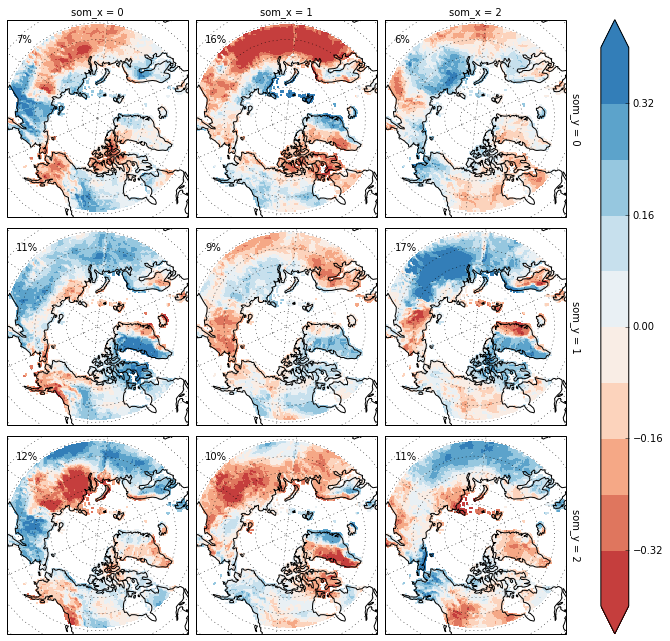

In [34]:
fg = k_da.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu',
                           robust=True, extend='both', levels=11,
                           subplot_kws=dict(projection=Rasm()),
                           transform=ccrs.PlateCarree())
for i in set(som_inds):
    fg.axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    set_map_features(fg.axes[i])

In [35]:
def map_to_som(da, like=k_da, som_inds=som_inds):
    mapped_som = full_like(like, fill_value=np.nan)

    for i in set(som_inds):
        bool_mask = [i == si for si in som_inds]
        mapped_som[dict(som_y=i[0], som_x=i[1])] = da.values[np.nonzero(bool_mask)[0]].mean(axis=0)
        
    return mapped_som

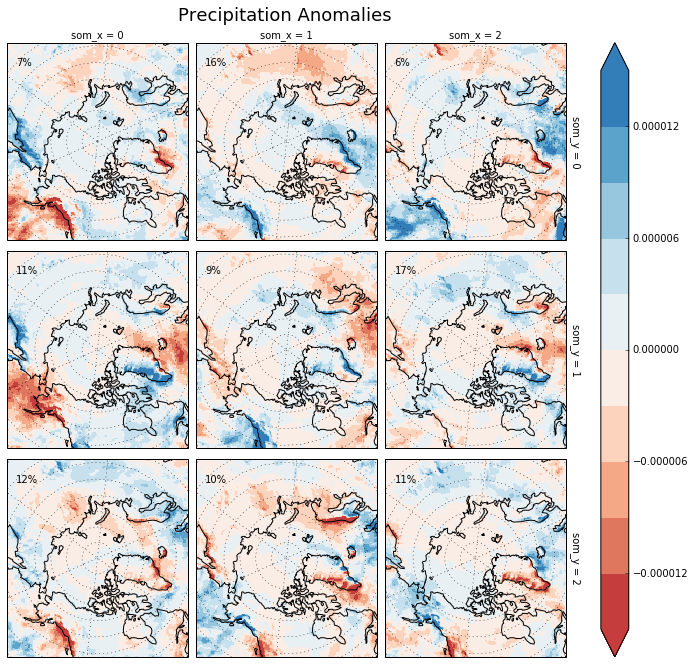

In [36]:
precip_anoms = precip_anoms.sel(time=precip_anoms.indexes['time'].month > 9) #.where(precip_anoms.yc > 55)
precip_mapped_som = full_like(k_da, fill_value=np.nan)

for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
#     if som_fracs[i] > som_fraction_threshold:
    precip_mapped_som[dict(som_y=i[0], som_x=i[1])] = precip_anoms.values[np.nonzero(bool_mask)[0]].mean(axis=0)

fg = precip_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu',
                                       robust=True, extend='both', levels=11,
                                       subplot_kws=dict(projection=Rasm()),
                                       transform=ccrs.PlateCarree())

for i in set(som_inds):
    fg.axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    set_map_features(fg.axes[i])
    
fg.fig.suptitle('Precipitation Anomalies', fontsize=18, y=1.02, x=0.4)

In [37]:
# sea_ice_ts = xr.open_dataset('../data/sea_ice_timeseries.nc')
# sea_ice_ts.sel(time=p_minus_e_anoms.indexes['time'].month > 9)

# sea_ice_ts_anoms = anomalies(sea_ice_ts.sel(dataset=u'$RASM_{CONTROL}$'), standardize=False)

# sea_ice_by_som = {}
# for i in set(som_inds):
#     bool_mask = [i == si for si in som_inds]
#     sea_ice_by_som[i] = sea_ice_ts_anoms.sel(time=sea_ice_ts_anoms.indexes['time'].month > 9)['area'][bool_mask].values.mean()

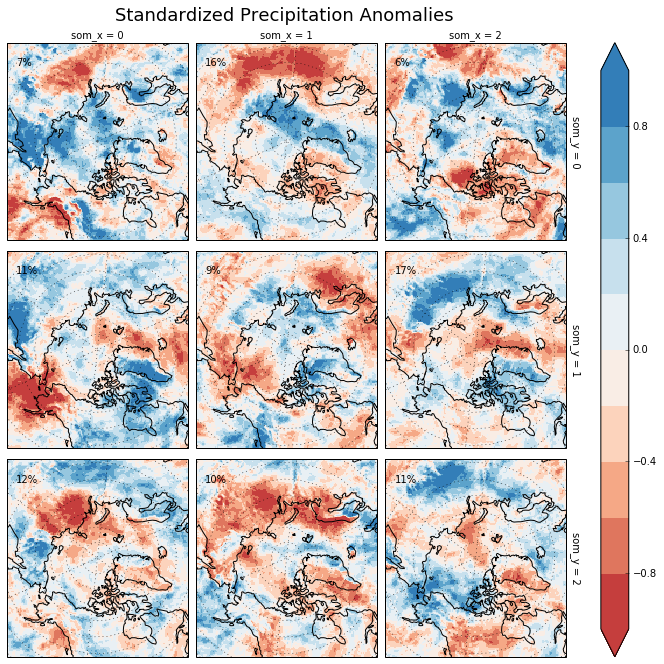

In [38]:
precip_anoms_std = precip_anoms_std.sel(time=precip_anoms_std.indexes['time'].month > 9) #.where(precip_anoms_std.yc > 55)
precip_mapped_som = full_like(k_da, fill_value=np.nan)

for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
#     if som_fracs[i] > som_fraction_threshold:
    precip_mapped_som[dict(som_y=i[0], som_x=i[1])] = precip_anoms_std.values[np.nonzero(bool_mask)[0]].mean(axis=0)
    
fg = precip_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu',
                                       robust=True, extend='both', levels=11,
                                       subplot_kws=dict(projection=Rasm()),
                                       transform=ccrs.PlateCarree())

for i in set(som_inds):
    fg.axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    set_map_features(fg.axes[i])
    
fg.fig.suptitle('Standardized Precipitation Anomalies', fontsize=18, y=1.02, x=0.4)

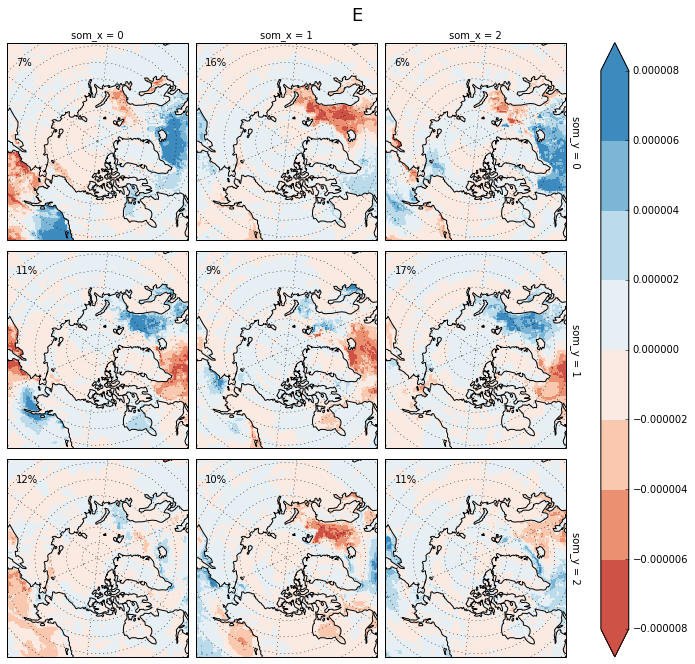

In [39]:
evap_anoms = evap_anoms.sel(time=evap_anoms.indexes['time'].month > 9) # .where(evap_anoms.yc > 55).where(ncdata['rasm_domain'].mask == 0)
evap_mapped_som = full_like(k_da, fill_value=np.nan)

for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
    evap_mapped_som[dict(som_y=i[0], som_x=i[1])] = evap_anoms.values[np.nonzero(bool_mask)[0]].mean(axis=0)
    
fg = evap_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu',
                                     robust=True, extend='both', levels=11,
                                     subplot_kws=dict(projection=Rasm()),
                                     transform=ccrs.PlateCarree())

for i in set(som_inds):
    fg.axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)   
    set_map_features(fg.axes[i])
    
fg.fig.suptitle('E', fontsize=18, y=1.02)

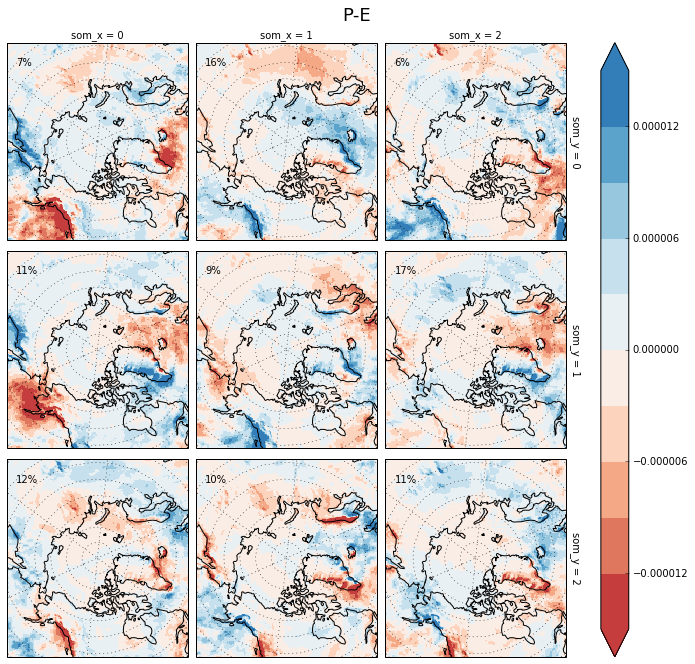

In [40]:
p_minus_e_anoms = p_minus_e_anoms.sel(time=p_minus_e_anoms.indexes['time'].month > 9) # .where(p_minus_e_anoms.yc > 55)
p_minus_e_mapped_som = full_like(k_da, fill_value=np.nan)

for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
    p_minus_e_mapped_som[dict(som_y=i[0], som_x=i[1])] = p_minus_e_anoms.values[np.nonzero(bool_mask)[0]].mean(axis=0)
    
fg = p_minus_e_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu',
                                     robust=True, extend='both', levels=11,
                                     subplot_kws=dict(projection=Rasm()),
                                     transform=ccrs.PlateCarree())

for i in set(som_inds):
    fg.axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    set_map_features(fg.axes[i])
    
fg.fig.suptitle('P-E', fontsize=18, y=1.02)

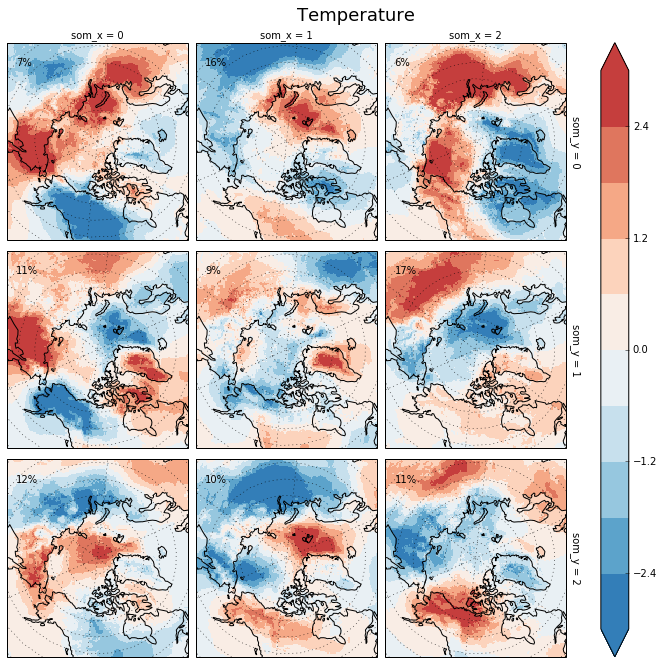

In [41]:
temp_anoms = temp_anoms.sel(time=temp_anoms.indexes['time'].month > 9) # .where(p_minus_e_anoms.yc > 55)
temp_mapped_som = full_like(k_da, fill_value=np.nan)

for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
    temp_mapped_som[dict(som_y=i[0], som_x=i[1])] = temp_anoms.values[np.nonzero(bool_mask)[0]].mean(axis=0)
    
fg = temp_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu_r',
                                     robust=True, extend='both', levels=11,
                                     subplot_kws=dict(projection=Rasm()),
                                     transform=ccrs.PlateCarree())

for i in set(som_inds):
    fg.axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    set_map_features(fg.axes[i])
    
fg.fig.suptitle('Temperature', fontsize=18, y=1.02)

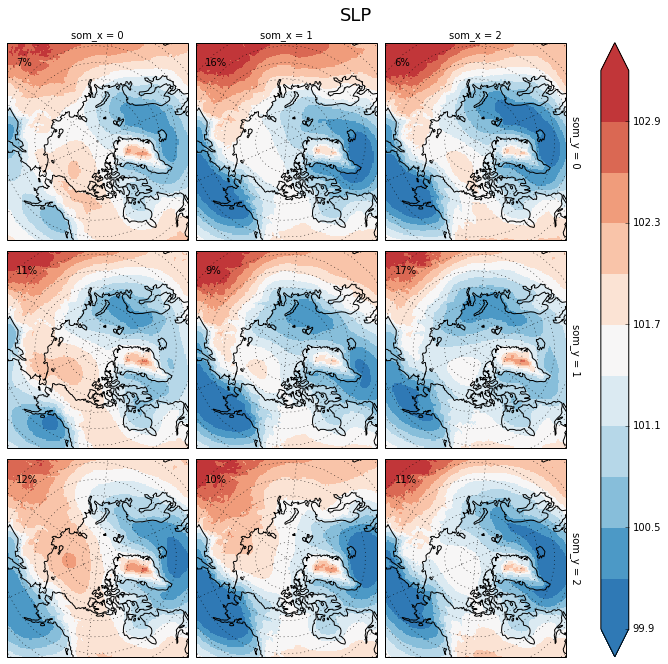

In [42]:
slp = ncdata['$RASM_{CONTROL}$'].a2xavg_Sa_pslv
slp_anoms = slp / 1000 #anomalies(slp, standardize=False)

slp_anoms = slp_anoms.sel(time=slp_anoms.indexes['time'].month > 9) # .where(p_minus_e_anoms.yc > 55)
slp_mapped_som = full_like(k_da, fill_value=np.nan)

for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
    slp_mapped_som[dict(som_y=i[0], som_x=i[1])] = slp_anoms.values[np.nonzero(bool_mask)[0]].mean(axis=0)
    
fg = slp_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu_r',
                                     robust=True, extend='both', levels=11,
                                     subplot_kws=dict(projection=Rasm()),
                                     transform=ccrs.PlateCarree())

for i in set(som_inds):
    fg.axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    set_map_features(fg.axes[i])
    
fg.fig.suptitle('SLP', fontsize=18, y=1.02)

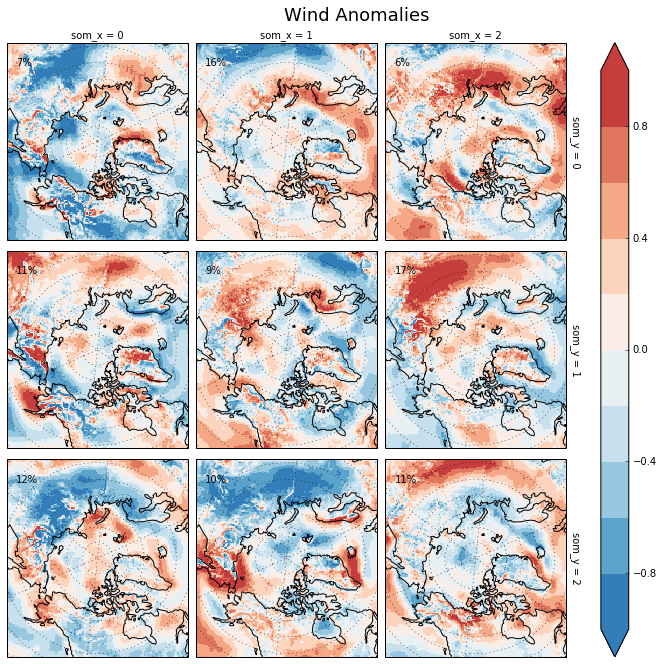

In [43]:
wind_speed = np.sqrt(ncdata['$RASM_{CONTROL}$'].a2xavg_Sa_u ** 2 + ncdata['$RASM_{CONTROL}$'].a2xavg_Sa_v ** 2)
wind_anoms = anomalies(wind_speed, standardize=True)

wind_anoms = wind_anoms.sel(time=wind_anoms.indexes['time'].month > 9) # .where(p_minus_e_anoms.yc > 55)
wind_mapped_som = full_like(k_da, fill_value=np.nan)

for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
    wind_mapped_som[dict(som_y=i[0], som_x=i[1])] = wind_anoms.values[np.nonzero(bool_mask)[0]].mean(axis=0)
    
fg = wind_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu_r',
                                     robust=True, extend='both', levels=11,
                                     subplot_kws=dict(projection=Rasm()),
                                     transform=ccrs.PlateCarree())

for i in set(som_inds):
    fg.axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    set_map_features(fg.axes[i])
    
fg.fig.suptitle('Wind Anomalies', fontsize=18, y=1.02)

In [29]:
wind_u = ncdata['$RASM_{CONTROL}$'].a2xavg_Sa_u.sel(
    time= ncdata['$RASM_{CONTROL}$'].a2xavg_Sa_u.indexes['time'].month > 9).where(p_minus_e_anoms.yc > 55)
wind_v = ncdata['$RASM_{CONTROL}$'].a2xavg_Sa_v.sel(
    time=ncdata['$RASM_{CONTROL}$'].a2xavg_Sa_v.indexes['time'].month > 9).where(p_minus_e_anoms.yc > 55)
wind_speed = np.sqrt(wind_u**2 + wind_v**2) 

wind_mapped_som = full_like(k_da, fill_value=np.nan)
wind_u_mapped_som = full_like(k_da, fill_value=np.nan)
wind_v_mapped_som = full_like(k_da, fill_value=np.nan)


for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
    wind_mapped_som[dict(som_y=i[0], som_x=i[1])] = wind_speed.values[np.nonzero(bool_mask)[0]].mean(axis=0)
    wind_u_mapped_som[dict(som_y=i[0], som_x=i[1])] = wind_u.values[np.nonzero(bool_mask)[0]].mean(axis=0)
    wind_v_mapped_som[dict(som_y=i[0], som_x=i[1])] = wind_v.values[np.nonzero(bool_mask)[0]].mean(axis=0)
    
# fg = wind_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='Reds',
#                                      robust=True, extend='max', levels=11,
#                                      subplot_kws=dict(projection=Rasm()),
#                                      transform=ccrs.PlateCarree())

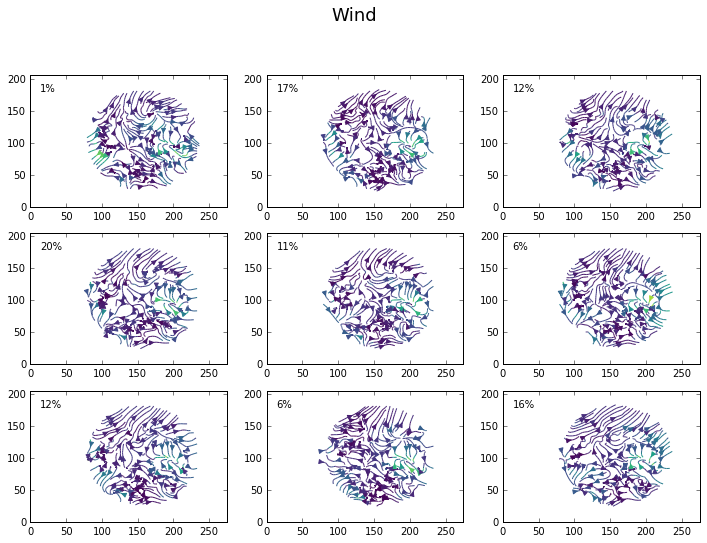

In [30]:
fig, axes = plt.subplots(*som_shape, figsize=(12, 8)) # subplot_kw=dict(projection=Rasm()), 

for i in set(som_inds):
    axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform=axes[i].transAxes)
    axes[i].streamplot(np.arange(0, 275),
                       np.arange(0, 205),
                          wind_u_mapped_som[dict(som_y=i[0], som_x=i[1])].values,
                          wind_v_mapped_som[dict(som_y=i[0], som_x=i[1])].values,
                          color=wind_mapped_som[dict(som_y=i[0], som_x=i[1])].values,
                          density=2, cmap='viridis',)
#                           transform=ccrs.PlateCarree())
#     set_map_features(axes[i])
    axes[i].set_ylim(0, 205)
    axes[i].set_xlim(0, 275)
    
fig.suptitle('Wind', fontsize=18, y=1.02)

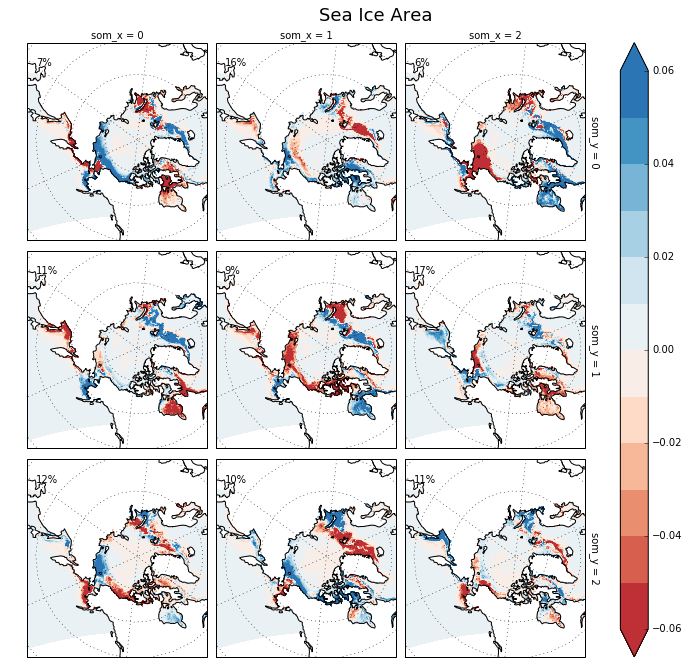

In [44]:
sea_ice_anoms = sea_ice_anoms.sel(time=sea_ice_anoms.indexes['time'].month > 9)

sea_ice_mapped_som = xr.DataArray(np.full(som_shape + sea_ice_anoms.shape[1:], np.nan),
                                  dims=('som_y', 'som_x') + sea_ice_anoms.dims[1:])

sea_ice_mapped_som.coords['xc'] = sea_ice_anoms['TLON']
sea_ice_mapped_som.coords['yc'] = sea_ice_anoms['TLAT']
sea_ice_mapped_som


for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
    sea_ice_mapped_som[dict(som_y=i[0], som_x=i[1])] = sea_ice_anoms.values[np.nonzero(bool_mask)[0]].mean(axis=0)
    
fg = sea_ice_mapped_som.plot.pcolormesh('TLON', 'TLAT', row='som_y', col='som_x', cmap='RdBu',
#                                         vmin=-0.1, vmax=0.1,
                                        extend='both', levels=12, robust=True,
                                        subplot_kws=dict(projection=Rasm()),
                                        transform=ccrs.PlateCarree())

for i in set(som_inds):
    fg.axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    set_map_features(fg.axes[i], extent=None)
    
fg.fig.suptitle('Sea Ice Area', fontsize=18, y=1.02)

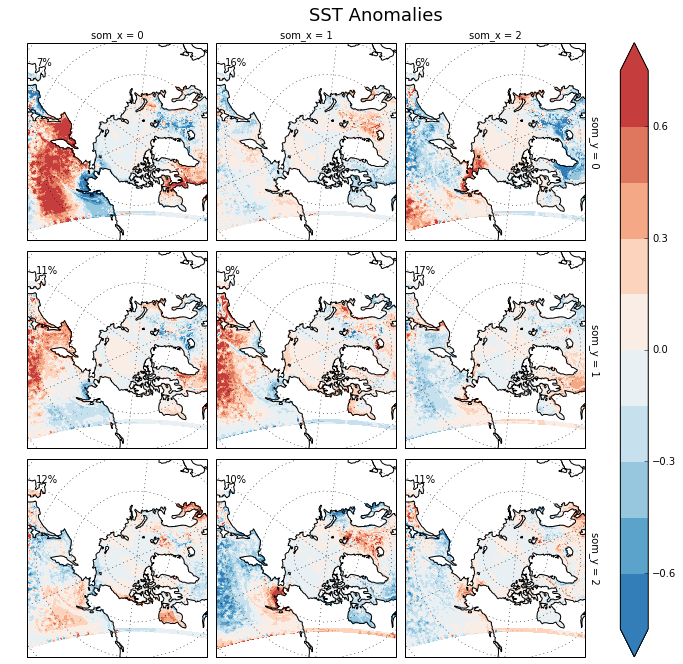

In [45]:
sst = ncdata['$RASM_{CONTROL}-OCN$']['TEMP'].squeeze()

sst_anoms = anomalies(sst.sel(time=sst.indexes['time'].month > 9), standardize=False) # .where(sst['TLAT'] > 55)

sst_mapped_som = xr.DataArray(np.full(som_shape + sst.shape[1:], np.nan),
                                  dims=('som_y', 'som_x') + sst.dims[1:])

sst_mapped_som.coords['xc'] = sst_anoms['TLONG']
sst_mapped_som.coords['yc'] = sst_anoms['TLAT']


for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
    sst_mapped_som[dict(som_y=i[0], som_x=i[1])] = sst_anoms.values[np.nonzero(bool_mask)[0]].mean(axis=0)
    
fg = sst_mapped_som.plot.pcolormesh('TLONG', 'TLAT', row='som_y', col='som_x', cmap='RdBu_r',
                                    extend='both', levels=12, robust=True,
                                    subplot_kws=dict(projection=Rasm()),
                                    transform=ccrs.PlateCarree())

for i in set(som_inds):
    fg.axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    set_map_features(fg.axes[i], extent=None)
    
fg.fig.suptitle('SST Anomalies', fontsize=18, y=1.02)

In [46]:
def sel_som_data(da):
    return da.sel(time=da.indexes['time'].month > 9) # .where(da.yc > 55)

In [47]:
composite_data = {'Precipitation': 86400 * map_to_som(sel_som_data(precip_anoms)),
                  'Evaporation': 86400 * map_to_som(sel_som_data(evap_anoms)),
                  'SLP': map_to_som(sel_som_data(slp / 1000)),
                  'Wind Anomalies': map_to_som(sel_som_data(anomalies(wind_speed, standardize=False))),
                  'SST Anomalies': map_to_som(sel_som_data(anomalies(sst.rename({'TLONG': 'xc', 'TLAT': 'yc'}), standardize=False)), like=sst_mapped_som),
                  'Sea Ice Anomalies': map_to_som(sel_som_data(sea_ice_anoms.rename({'TLON': 'xc', 'TLAT': 'yc'})), like=sst_mapped_som),
                 }

for v in ['SST Anomalies', 'Sea Ice Anomalies']:
    composite_data[v]['xc'].values = ncdata['rasm_ocn_masks']['ULON'].values
    composite_data[v]['yc'].values = ncdata['rasm_ocn_masks']['ULAT'].values

In [48]:
composite_plot_args = {'Precipitation': dict(vmin=-0.7, vmax=0.7, cmap='RdBu', extend='both', levels=12, label=''),
                       'Evaporation': dict(vmin=-0.7, vmax=0.7, cmap='RdBu', extend='both', levels=12),
                       'SLP': dict(vmin=99.325, vmax=103.325, cmap='RdBu_r', extend='both', levels=12),
                       'Wind Anomalies': dict(vmin=-1, vmax=1, cmap='RdBu_r', extend='both', levels=12),
                       'SST Anomalies': dict(vmin=-0.7, vmax=0.7, cmap='RdBu_r', extend='both', levels=12),
                       'Sea Ice Anomalies': dict(vmin=-0.1, vmax=0.1, cmap='RdBu', extend='both', levels=12),
                 }

labels = {'Precipitation': 'Precipitation Anom.\n(std. anoms.)',
          'Evaporation': 'Evaporation Anom.\n(std. anoms.)',
          'SLP': 'SLP\n(kPa)',
          'Wind Anomalies': 'Wind Anom.\n(m/s)',
          'SST Anomalies': 'SST Anoms.\n(C)',
          'Sea Ice Anomalies': 'Sea Ice Concentration\n(frac)'}

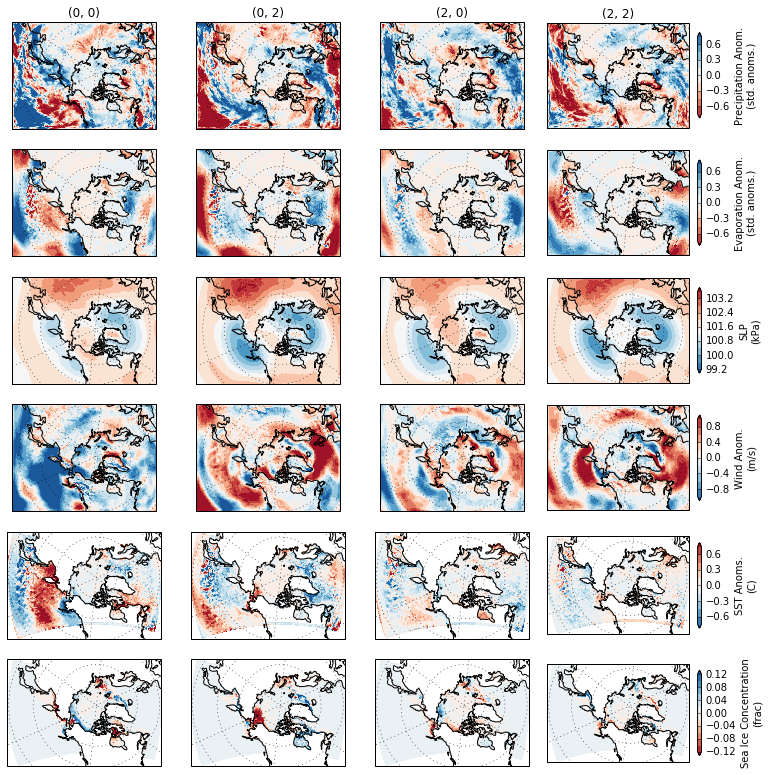

In [49]:
# composite som figure
composite_som_inds = [(0, 0), (0, 2), (2, 0), (2, 2)] # corners
variables = ['Precipitation', 'Evaporation', 'SLP', 'Wind Anomalies', 'SST Anomalies', 'Sea Ice Anomalies']

fig, axes = plt.subplots(len(variables), len(composite_som_inds), figsize=(11, 11),
                         subplot_kw=dict(projection=Rasm()))

for i, var in enumerate(variables):
    for j, ind in enumerate(composite_som_inds):
        ax = axes[i, j]
        da = composite_data[var][dict(som_y=ind[0],
                                      som_x=ind[1])]
        
        if j == len(composite_som_inds) - 1:
            composite_plot_args[var]['add_colorbar'] = True
            composite_plot_args[var]['cbar_kwargs'] = dict(shrink=0.8, label=labels[var])
        else:
            composite_plot_args[var]['add_colorbar'] = False
            composite_plot_args[var].pop('cbar_kwargs', None)

        
        m = da.plot.pcolormesh('xc', 'yc',
                               ax=ax, transform=ccrs.PlateCarree(),
                               **composite_plot_args[var])
        set_map_features(ax, extent=None)
        
        if i == 0:
            ax.set_title(ind)
        else:
            ax.set_title('')
        
fig.tight_layout()

# fig.savefig('../figs/composite_som.png', dpi=300)